# Modelling Intrusion Detection: Analysis of a Feature Selection Mechanism

In [1]:
import pandas as pd
import numpy as np
from time import time
import sys
import sklearn
import matplotlib.pyplot as plt
print(pd.__version__)
print(np.__version__)
print(sys.version)
print(sklearn.__version__)

0.23.0
1.14.3
3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]
0.19.1


## Load the Dataset

In [34]:



col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]
kdd_data_10percent = pd.read_csv("kddcup.data_10_percent_corrected", header=None, names = col_names)
kdd_data_10percent.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,...,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,...,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
kdd_data_10percent.shape

(494021, 42)

In [38]:
print('Label distribution Training set:')
print(kdd_data_10percent["label"].value_counts())

Label distribution Training set:
smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: label, dtype: int64


In [39]:
from sklearn.neighbors import KNeighborsClassifier
labels = kdd_data_10percent['label'].copy()
labels[labels!='normal.'] = 'attack.'
labels.value_counts()

attack.    396743
normal.     97278
Name: label, dtype: int64

# Log-scaled distribution of attacks



<Figure size 432x288 with 0 Axes>

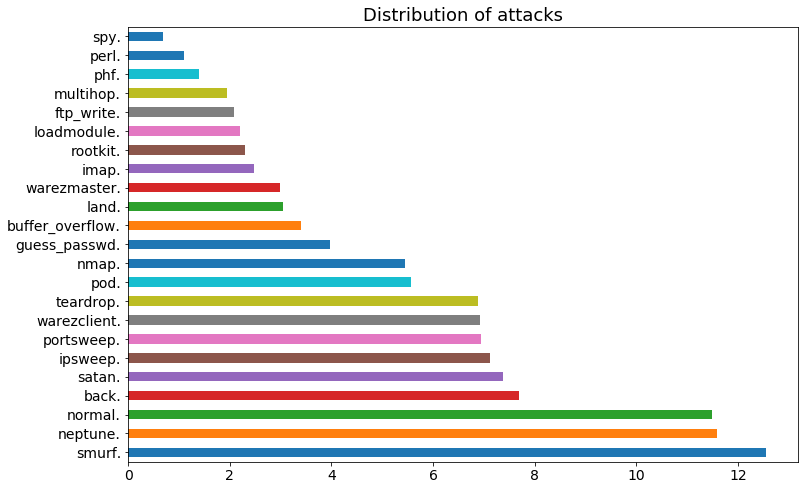

In [40]:
plt.clf()
plt.figure(figsize=(12,8))
params = {'axes.titlesize':'18',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14'}
matplotlib.rcParams.update(params)
plt.title('Distribution of attacks')
#df.plot(kind='barh')
kdd_data_10percent['label'].value_counts().apply(np.log).plot(kind='barh')
plt.show()

# KDD skewness and kurtosis¶

In [42]:
kdd_data_10percent.skew().head()

duration           25.864857
src_bytes         699.213151
dst_bytes         136.759278
land              149.842038
wrong_fragment     21.718929
dtype: float64

In [43]:
kdd_data_10percent.kurtosis().head()

duration             942.530243
src_bytes         490584.345621
dst_bytes          20338.143392
land               22450.727280
wrong_fragment       476.087532
dtype: float64


# Univariate histogramms¶




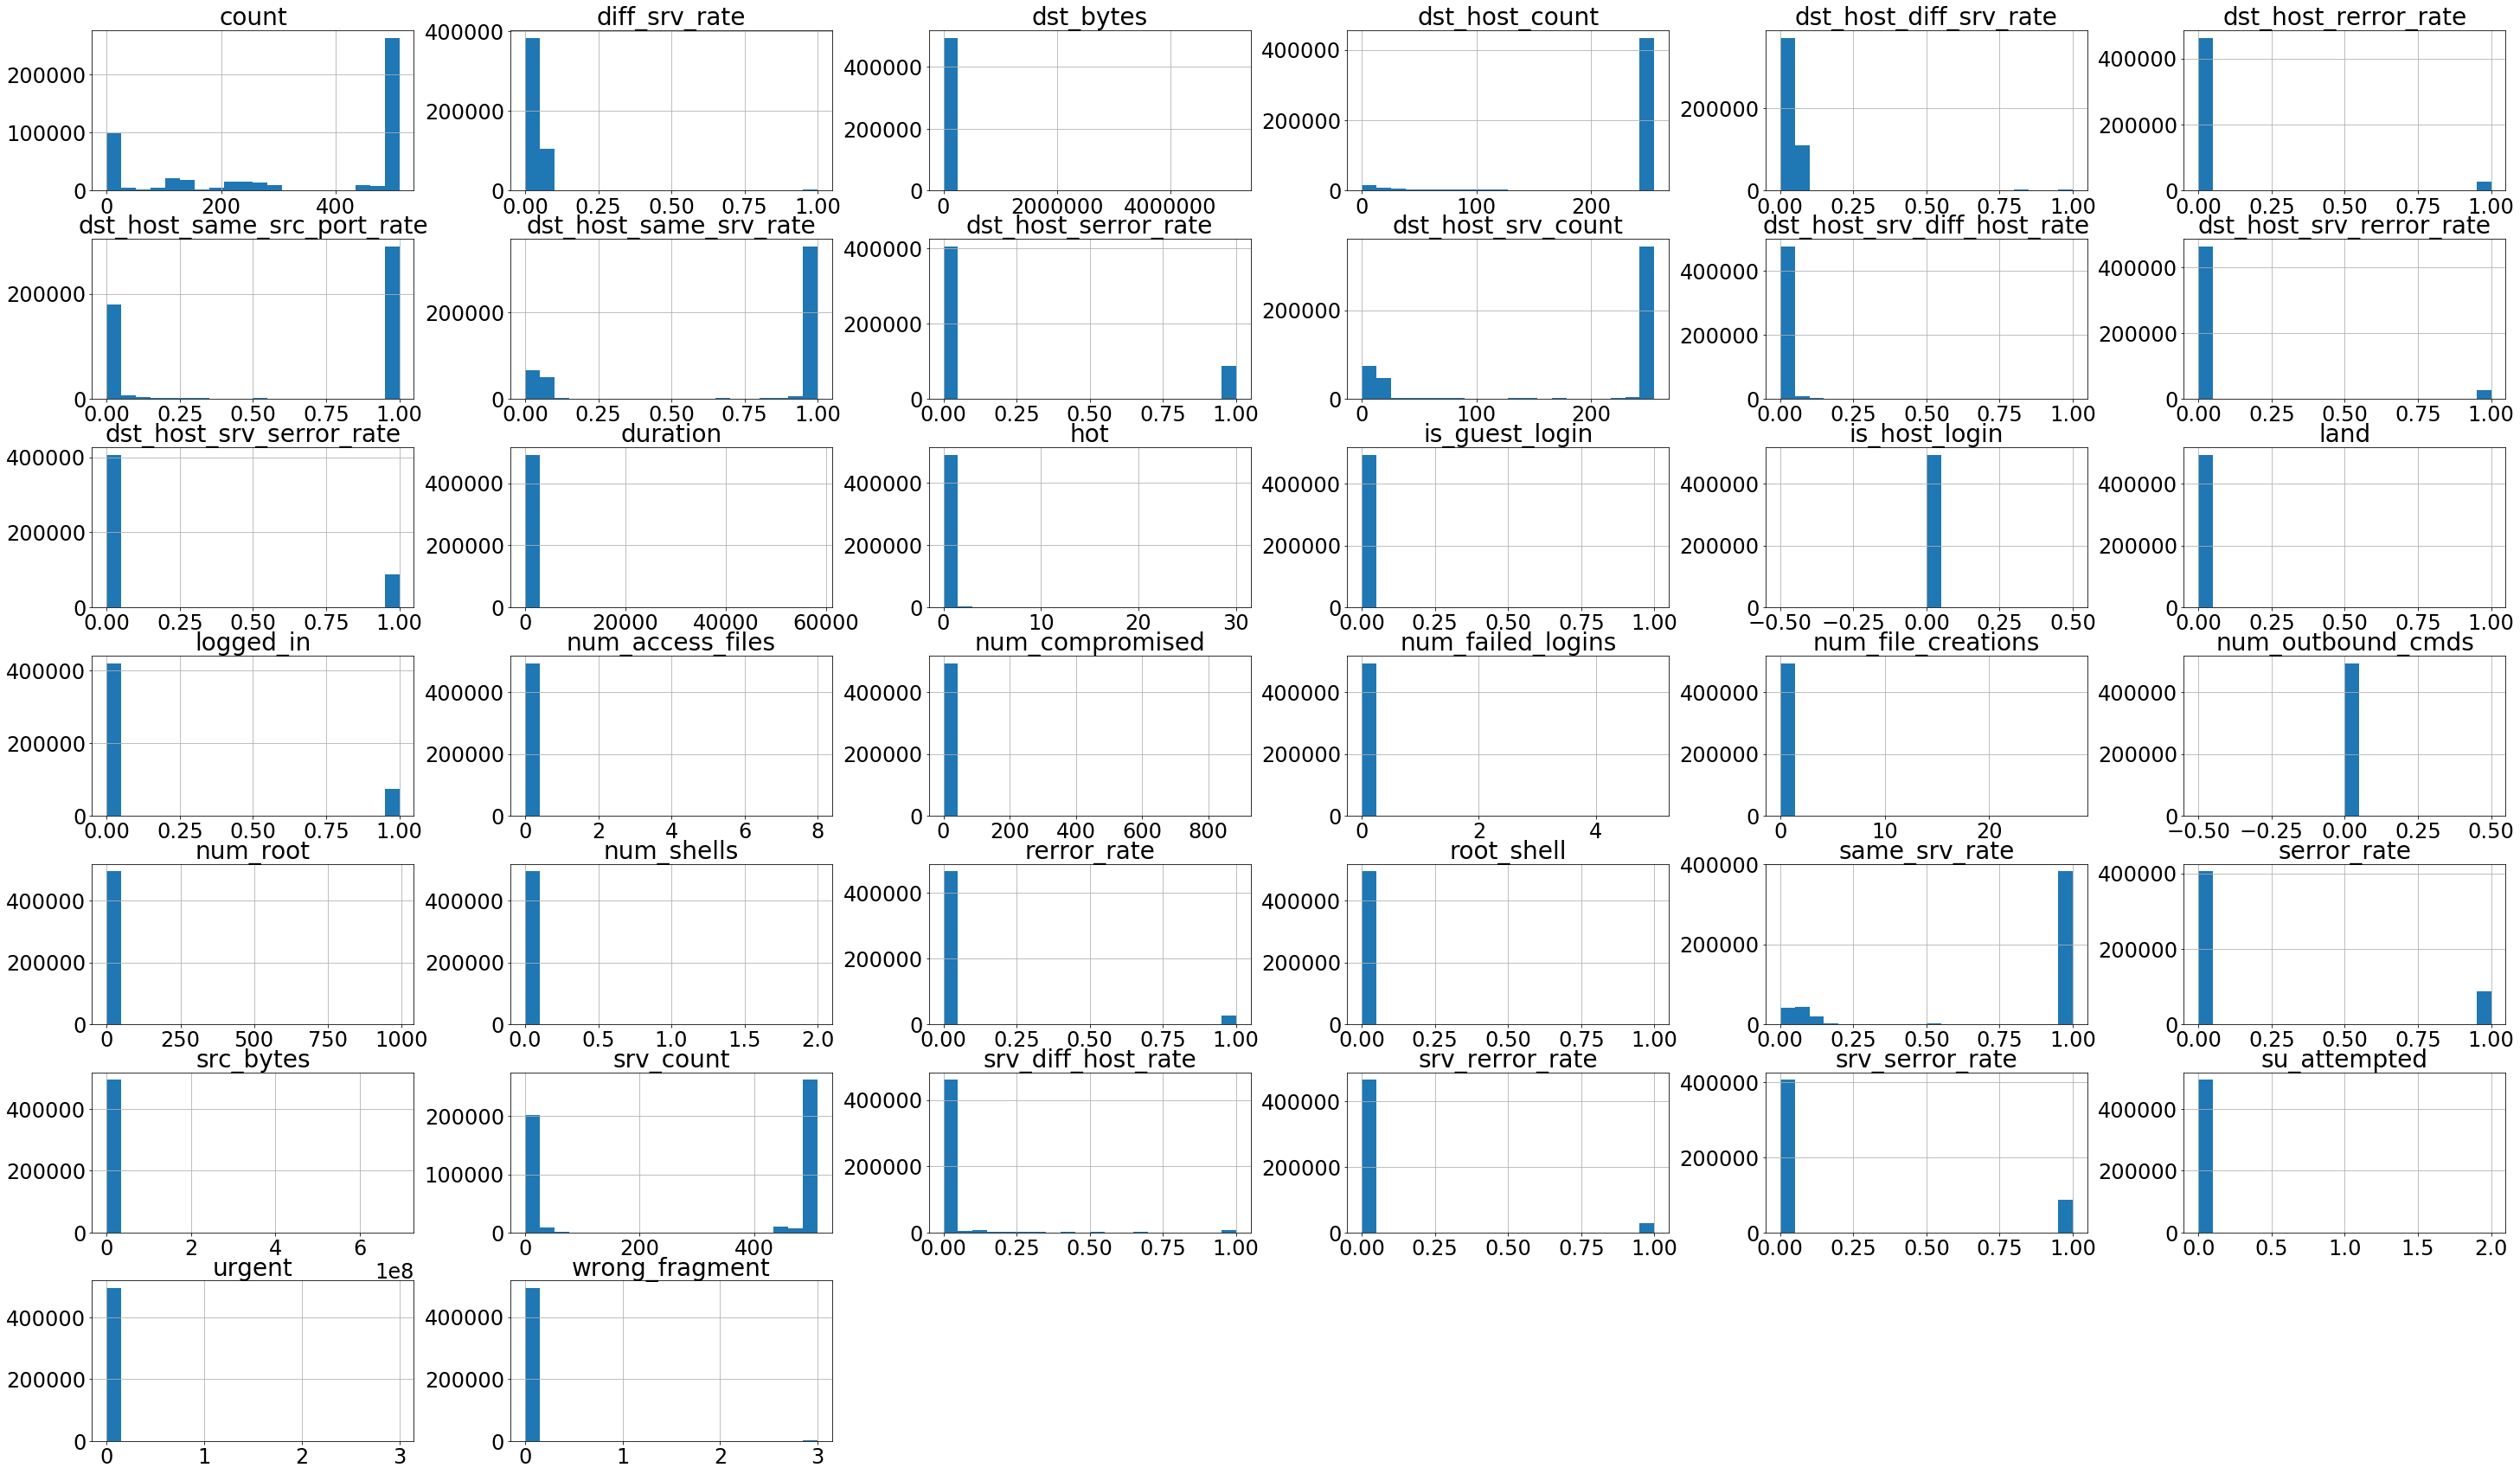

In [45]:
import matplotlib.pyplot as plt
import matplotlib
params = {'axes.titlesize':'28',
          'xtick.labelsize':'24',
          'ytick.labelsize':'24'}
matplotlib.rcParams.update(params)
kdd_data_10percent.hist(figsize=(50, 30), bins=20)
plt.show()

# Analysis of discrete differences in relation to attacks 
and network services We will analyze the relationship or 
service of the network used to allocate two pairs of identified attacks.
To do this, we will draw a bar graph that shows the percentage of participation of each network service in
each attack.  To facilitate viewing, we will only consider attacks that represent at least 1% 
of the total percentage of attacks or types of network services.

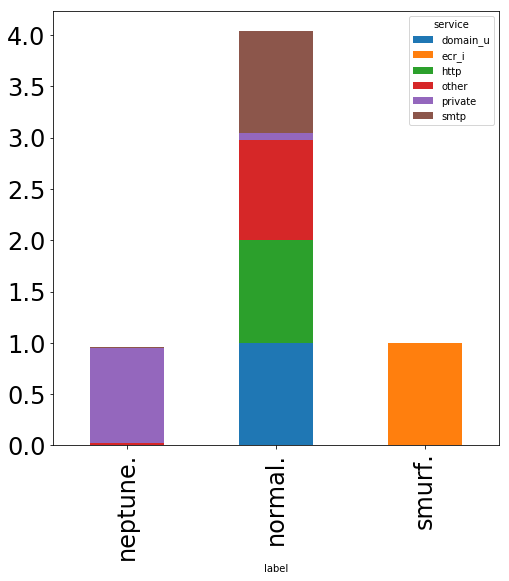

In [60]:
## Create a subset of main dataset (f_data) that contains only services and labels that represents at
## least 1% of the total cases

f_services = pd.crosstab(index=kdd_data_10percent["service"],columns="count")
f_services = f_services/len(kdd_data_10percent)
f_services = f_services[f_services["count"] > 0.01]

f_attacks = pd.crosstab(index=kdd_data_10percent["label"],columns="count")
f_attacks = f_attacks/len(kdd_data_10percent)
f_attacks = f_attacks[f_attacks["count"] > 0.01]

f_data = kdd_data_10percent[kdd_data_10percent['service'].isin(list(f_services.index))]
f_data = f_data[f_data['label'].isin(list(f_attacks.index))]

## Create the plot

attack_data = pd.crosstab(index = f_data["label"], columns=f_data["service"])
frequency_table_attack = (attack_data/attack_data.sum())

frequency_table_attack.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=True);


Through the graph you can see some important characteristics of two dice, such as the main types of current attack and protocol used.  We see that clearly a greater part of the network of networks present a set of data is not characterized as "normal", or seja, a network flow is a type of malicious activity detected.  In addition, the main attacks that are present are given by SYN Flood (Neptune), guess_passord, mailbomb and Smurf. 



# Relationship between Attacks and Protocol
Types Using the previous mesma approach, we will evaluate or participate the percentage of each network protocol in each type of attack.  Or, analyze and visualize objectively there is some feature that can be found in the literature

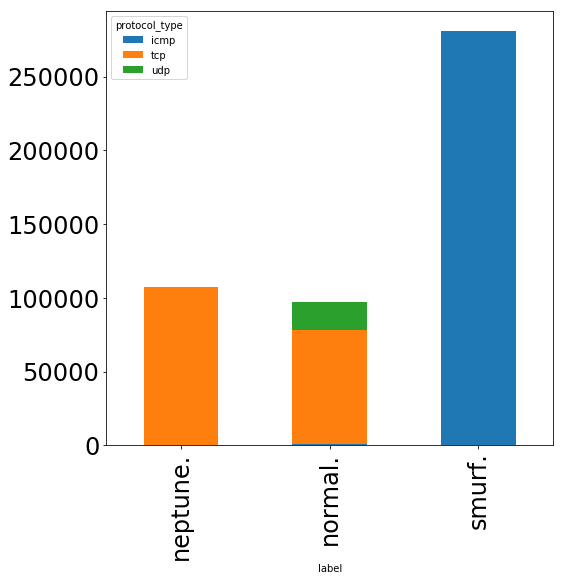

In [61]:
## Create a subset of main dataset (f_data) that contains only protocols and labels that represents at
## least 1% of the total cases

f_protocol = pd.crosstab(index=kdd_data_10percent["protocol_type"],columns="count")
f_protocol = f_protocol/len(kdd_data_10percent)
f_protocol = f_protocol[f_protocol["count"] > 0.01]

f_data = kdd_data_10percent[kdd_data_10percent['protocol_type'].isin(list(f_protocol.index))]
f_data = f_data[f_data['label'].isin(list(f_attacks.index))]

## Create a Two-Way Table

relationship_protocoal_attack = pd.crosstab(index=f_data["label"], 
                          columns=f_data["protocol_type"])
## Plot the Two-Way Table
relationship_protocoal_attack.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=True);

 it was expected to provide literature data, attacks of type 
SYN Flood (Neptune) ocorreram in networks with TCP protocol and Smurf attacks in ICMP networks.
We can also note that attacks of type SNMP foram feitos exclusively in networks that utizam UDP. 

# Percentage of participation of each type of network protocol or Abaixo
graphic visa to give an overview of the participation of each type of protocol in the network that the data foram collected

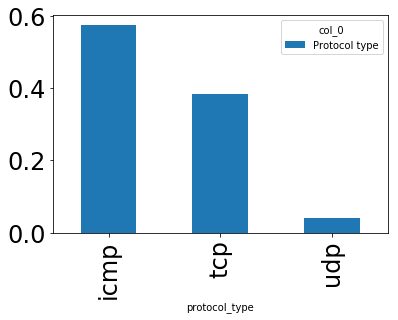

In [63]:
## Create a cross tab dataframe
protocol_data = pd.crosstab(index = kdd_data_10percent["protocol_type"],columns="Protocol type")
frequency_table_protocol = (protocol_data/protocol_data.sum())
## Plot the dataframe
frequency_table_protocol.plot.bar();



# Analysis of continuous variances 
# nalyze two users logged not system 

We deem it interesting to evaluate the behavior pattern of users who are somehow logged into the network. In this way, we will create graphs that analyze if any threats were detected for the following types of users:


 users registered as guests; 
 Users of the list of ¨hot¨


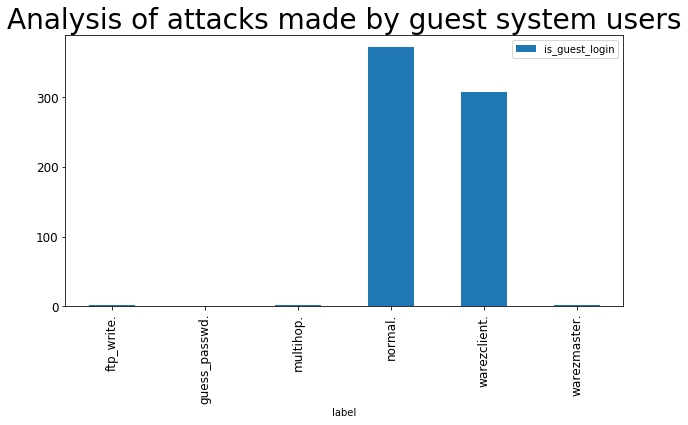

In [66]:
df_temp = kdd_data_10percent[["is_guest_login","label"]]
df_temp = df_temp.loc[df_temp['is_guest_login'] == 1]
df_temp.groupby(["label"]).count().plot(kind='bar', title ="Analysis of attacks made by guest system users", figsize=(10, 5), legend=True, fontsize=12)

# We note that all attacks identified in this category of users are of type R2L (remote to local).

Attacks of this type occur when an attacker has the ability to send packets to a machine through the network, but does not have an account on that machine and exploits some vulnerability to gain local access as a machine user. That is, probably those identified "guest users" probably had their login hacked by the attacker.


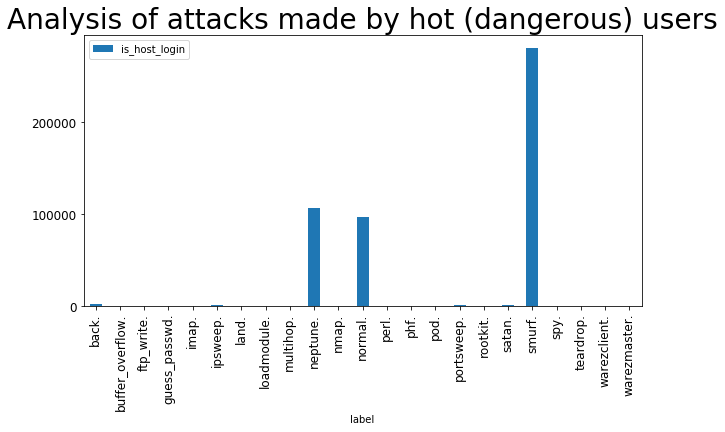

In [80]:
df_temp = kdd_data_10percent[["is_host_login","label"]]
df_temp = df_temp.loc[df_temp["is_host_login"] == 0]
df_temp.groupby(["label"]).count().plot(kind='bar', title ="Analysis of attacks made by hot (dangerous) users", figsize=(10, 5), legend=True, fontsize=12)


In this case we also have U2R (User to Root attack) attacks.
In this case the attacker accesses the system as a normal user (gained by: sniffing password,
a local dictionary or social engineering) and starts exploiting vulnerabilities to gain root access to the system.

# Redundant Data Analysis

According to Tavallaee (2009), the large number of redundant records can bias the classifiers to the most frequent records.
In this way, the author proposes a new dataset, removing the duplicates. 
Thus, we will analyze the complete KDD99 dataset and the no duplicates. 
For this we will analyze the ratio between single and duplicate data and plot the relationship graph between attacks and services,
and between attacks and protocols used.

In [74]:
# Removing dupicates
df_no_duplicates = kdd_data_10percent.drop_duplicates()
percentage = 1 - float(df_no_duplicates["protocol_type"].count())/float(kdd_data_10percent["protocol_type"].count())
print("\n O dataset sem duplicatas é {}% menor que o dataset original,".format(round(percentage * 100,2)))


 O dataset sem duplicatas é 70.53% menor que o dataset original,


# Classification models

Before we run our models, let's make some changes to our dataset. Are they:
1. Transform categories that are strings into numeric categories

This transformation is necessary so that we can use the literal variables in the models, since some only support numeric variables
2. Assign a binary category of attack or non-attack to each of the registers

The main function of IDS is to detect whether or not an attack is happening, regardless of its type. Thus, we performed the binarization of the classification in order to discover how the models behave in the detection of attacks in a generic way, and can be used in a real IDS.
3. Create one set of data for training and another for testing and validating the models, using the ratio (0.8 / 0.2) ¶

In [82]:
# Mapping strings categories to int
from sklearn.cross_validation import train_test_split
df_binary = kdd_data_10percent.copy()
df_binary.loc[df_binary.label != 'normal.','label']= 1
df_binary.loc[df_binary.label == 'normal.','label']= 0

df_binary_duplicates = df_no_duplicates.copy()
df_binary_duplicates.loc[df_binary_duplicates.label != 'normal.','label']= 1
df_binary_duplicates.loc[df_binary_duplicates.label == 'normal.','label']= 0


c1 = df_binary.protocol_type.unique()
c2 = df_binary.service.unique()
c3 = df_binary.flag.unique()

d_protocol = {}
d_service = {}
d_flag = {}

for i in range(len(c1)):
    d_protocol[c1[i]] = i

for i in range(len(c2)):
    d_service[c2[i]] = i
    
for i in range(len(c3)):
    d_flag[c3[i]] = i

    
for i in d_protocol:
    df_binary        = df_binary.replace(i, d_protocol[i])
    df_binary_duplicates = df_binary_duplicates.replace(i, d_protocol[i])
    df_no_duplicates = df_no_duplicates.replace(i, d_protocol[i])
    kdd_data_10percent               = kdd_data_10percent.replace(i, d_protocol[i])
for i in d_service:
    df_binary        = df_binary.replace(i, d_service[i])
    df_binary_duplicates = df_binary_duplicates.replace(i, d_service[i])
    df_no_duplicates = df_no_duplicates.replace(i, d_service[i])
    kdd_data_10percent               = kdd_data_10percent.replace(i, d_service[i])
for i in d_flag:
    df_binary        = df_binary.replace(i, d_flag[i])
    df_binary_duplicates = df_binary_duplicates.replace(i, d_flag[i])
    df_no_duplicates = df_no_duplicates.replace(i, d_flag[i])
    kdd_data_10percent               = kdd_data_10percent.replace(i, d_flag[i])

import random
random.seed(1610)

## Split the data in train and test datasets (with duplicates)

df_b = df_binary.copy()
y_b = pd.factorize(df_b['label'])[0]
df_b = df_b.drop('label', 1)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(df_b, y_b, test_size=0.2, random_state=42)


## Split the data in train and test datasets (without duplicates)
df_b_nd = df_binary_duplicates.copy()
y_b_nd = pd.factorize(df_b_nd['label'])[0]
df_b_nd = df_b_nd.drop('label', 1)
X_train_bnd, X_test_bnd, y_train_bnd, y_test_bnd = train_test_split(df_b_nd, y_b_nd, test_size=0.2, random_state=42)


# Dataset (non binary) with duplicates

df_temp = kdd_data_10percent.copy()
y = df_temp['label']
df_temp = df_temp.drop('label', 1)
X_train, X_test, y_train, y_test = train_test_split(df_temp, y, test_size=0.2, random_state=42)

# Dataset (non binary) without duplicates

df_nd  = df_no_duplicates.copy()
y_nd = df_nd['label']
df_nd = df_nd.drop('label', 1)
X_train_nd, X_test_nd, y_train_nd, y_test_nd = train_test_split(df_nd , y_nd, test_size=0.2, random_state=42)

/home/sylla/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train_nd, X_train_nd))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat6))



In [84]:
# Creating array of dicts containing datasets
models = [{"name":"Binario com duplicatas","X":X_train_b,"Y":y_train_b,"X_test":X_test_b,"Y_test":y_test_b, "slug":"b"},
         {"name":"Binario sem duplicatas","X":X_train_bnd,"Y":y_train_bnd,"X_test":X_test_bnd,"Y_test":y_test_bnd, "slug":"bnd"},
         {"name":"Nao binario com duplicatas","X":X_train,"Y":y_train,"X_test":X_test,"Y_test":y_test, "slug":"nb"},
         {"name":"Nao binario sem duplicatas","X":X_train_nd,"Y":y_train_nd,"X_test":X_test_nd,"Y_test":y_test_nd, "slug":"nbnd"}]

# Training the Algorithm

# Analyzing a Dataset

In [5]:
# Divide by class 
df_normal = kdd_data_10percent[kdd_data_10percent['label'] == 'normal.']
df_neptune = kdd_data_10percent[kdd_data_10percent['label'] == 'neptune.']
df_back = kdd_data_10percent[kdd_data_10percent['label'] == 'back.']
df_teardrop = kdd_data_10percent[kdd_data_10percent['label'] == 'teardrop.']
df_satan = kdd_data_10percent[kdd_data_10percent['label'] == 'satan.']
df_warezclient = kdd_data_10percent[kdd_data_10percent['label'] == 'warezclient.']
df_ipsweep = kdd_data_10percent[kdd_data_10percent['label'] == 'ipsweep.']
df_smurf = kdd_data_10percent[kdd_data_10percent['label'] == 'smurf.']
df_portsweep = kdd_data_10percent[kdd_data_10percent['label'] == 'portsweep.']
df_pod = kdd_data_10percent[kdd_data_10percent['label'] == 'pod.']
df_nmap = kdd_data_10percent[kdd_data_10percent['label'] == 'nmap.']
df_guess_passwd = kdd_data_10percent[kdd_data_10percent['label'] == 'guess_passwd.']
df_buffer_overflow = kdd_data_10percent[kdd_data_10percent['label'] == 'buffer_overflow.']
df_warezmaster = kdd_data_10percent[kdd_data_10percent['label'] == 'warezmaster.']
df_land = kdd_data_10percent[kdd_data_10percent['label'] == 'land.']
df_imap = kdd_data_10percent[kdd_data_10percent['label'] == 'imap.']
df_rootkit = kdd_data_10percent[kdd_data_10percent['label'] == 'rootkit.']
df_loadmodule = kdd_data_10percent[kdd_data_10percent['label'] == 'loadmodule.']
df_ftp_write = kdd_data_10percent[kdd_data_10percent['label'] == 'ftp_write.']
df_multihop = kdd_data_10percent[kdd_data_10percent['label'] == 'multihop.']
df_phf = kdd_data_10percent[kdd_data_10percent['label'] == 'phf.']
df_perl = kdd_data_10percent[kdd_data_10percent['label'] == 'perl.']

In [6]:
kdd_data_10percent = pd.concat([df_normal, df_neptune, df_smurf], axis=0)

In [7]:
kdd_data_10percent.drop('num_outbound_cmds', axis=1, inplace=True)
kdd_data_10percent.drop('is_host_login', axis=1, inplace=True)
kdd_data_10percent['protocol_type'] = kdd_data_10percent['protocol_type'].astype('category')
kdd_data_10percent['service'] = kdd_data_10percent['service'].astype('category')
kdd_data_10percent['flag'] = kdd_data_10percent['flag'].astype('category')
kdd_data_10percent['label'] = kdd_data_10percent['label'].astype('category')
cat_columns = kdd_data_10percent.select_dtypes(['category']).columns
kdd_data_10percent[cat_columns] = kdd_data_10percent[cat_columns].apply(lambda x: x.cat.codes)

In [8]:
data = kdd_data_10percent.values
Y = data[:,39]
X = data[:,0:39]
Y = Y.reshape(-1, 1)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sScaler = StandardScaler()
rescaleX = sScaler.fit_transform(X)
pca = PCA(n_components=2)
rescaleX = pca.fit_transform(rescaleX)
rescaleX = np.append(rescaleX, Y, axis=1)
principalDf = pd.DataFrame(data = rescaleX, columns = ['principal component 1', 'principal component 2', 'label'])
principalDf.head()

,principal component 1,principal component 2,label
0,0.560535,1.428891,1.0
1,0.561570,1.404600,1.0
2,0.541429,1.380524,1.0
3,0.514420,1.354876,1.0
4,0.488805,1.329316,1.0


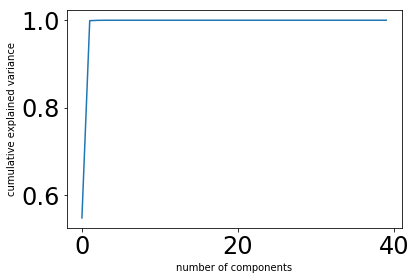

In [46]:
# Choosing the number of components
import matplotlib.pyplot as plt

plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show();

In [ ]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Data for three-dimensional scattered points
ax.scatter3D(principalDf.iloc[:,0], principalDf.iloc[:,1], principalDf.iloc[:,2], c=labels, s=50, cmap='spring')

plt.show()

In [9]:
principalDf.label.value_counts()

2.0    280790
0.0    107201
1.0     97278
Name: label, dtype: int64

<Figure size 432x288 with 0 Axes>

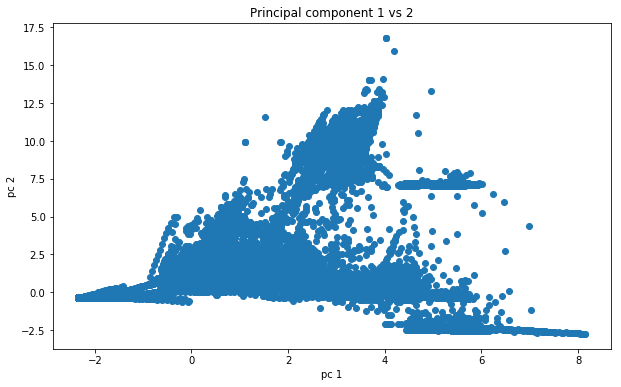

In [10]:
plt.clf()
plt.figure(figsize=(10,6))
plt.scatter(principalDf.iloc[:,0], principalDf.iloc[:,1])
plt.title('Principal component 1 vs 2')
plt.xlabel("pc 1")
plt.ylabel("pc 2")
plt.show()


In [11]:


data = principalDf.values


In [12]:
target = data[:,2]

In [13]:

principalDf.label.value_counts()

2.0    280790
0.0    107201
1.0     97278
Name: label, dtype: int64

In [14]:
names = ['neptune', 'normal', 'smurf']


<Figure size 432x288 with 0 Axes>

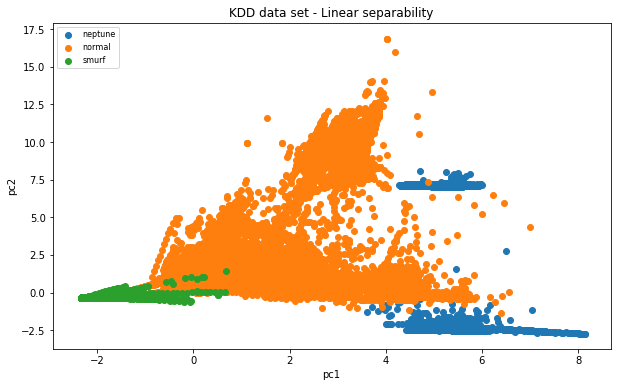

In [15]:
plt.clf()
plt.figure(figsize = (10, 6))
#markers = ['o', 's']
#label = numpy array of target column
plt.title('KDD data set - Linear separability')
plt.xlabel('pc1')
plt.ylabel('pc2')
for i in range(len(names)):
    bucket = principalDf[principalDf['label'] == i]
    bucket = bucket.iloc[:,[0,1]].values
    plt.scatter(bucket[:, 0], bucket[:, 1], label=names[i]) 
plt.legend(loc='upper left',
           fontsize=8)
plt.show()

<Figure size 432x288 with 0 Axes>

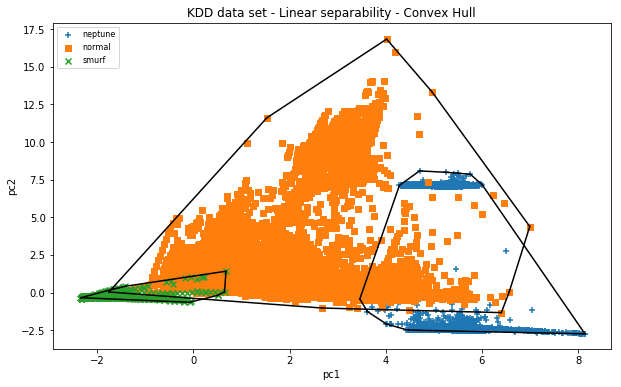

In [16]:
from scipy.spatial import ConvexHull
 
plt.clf()
plt.figure(figsize = (10, 6))
plt.title('KDD data set - Linear separability - Convex Hull')
plt.xlabel('pc1')
plt.ylabel('pc2')
markers = ['+', 's', 'x']
for i in range(len(names)):
    bucket = principalDf[principalDf['label'] == i]
    bucket = bucket.iloc[:,[0,1]].values
    hull = ConvexHull(bucket)
    plt.scatter(bucket[:, 0], bucket[:, 1], label=names[i], marker=markers[i]) 
    for j in hull.simplices:
        plt.plot(bucket[j,0], bucket[j,1], color='#000000')
plt.legend(loc='upper left',
           fontsize=8)
plt.show()

# Visualizing Clusters using PCA

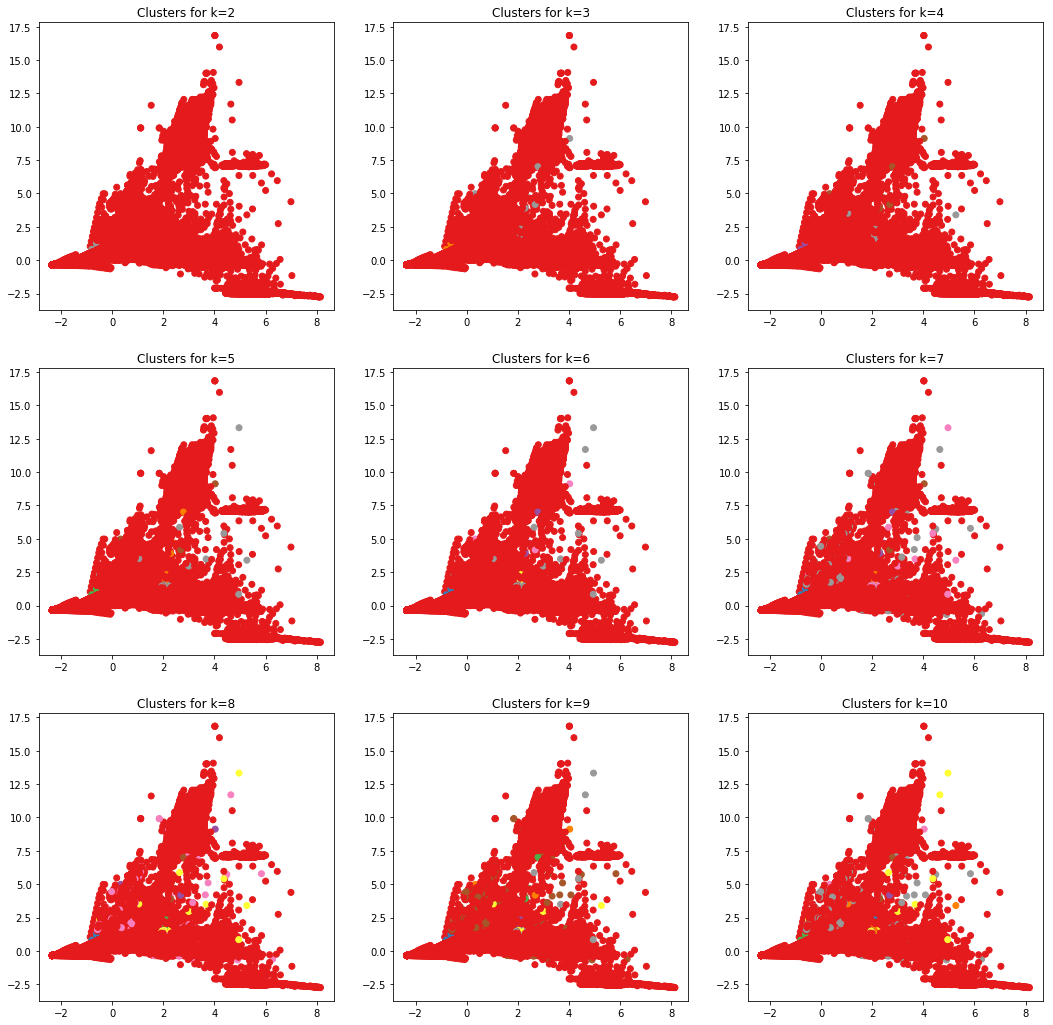

In [17]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib

x_cols = np.array(kdd_data_10percent.iloc[:, :42])
ks = range(2, 11)
fig = plt.figure(figsize=(18, 18))
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=2)
    labels = kmeans.fit_predict(x_cols)
    axes = fig.add_subplot(3, 3, k-1)
    axes.scatter(principalDf.iloc[:,0], principalDf.iloc[:,1], c=labels, cmap='Set1')
    axes.set(title='Clusters for k={}'.format(k))

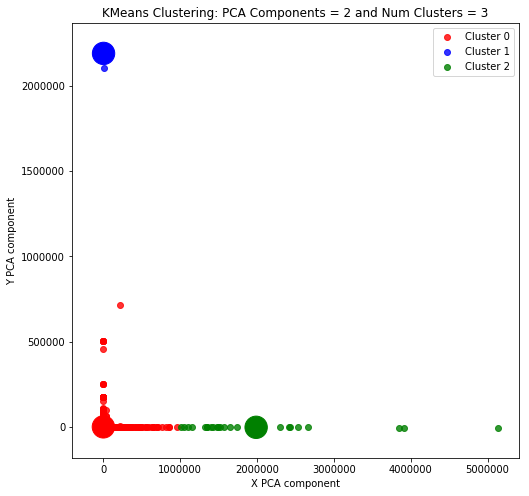

In [18]:
# Pick 3 clusters
k = 3
kmeans = KMeans(n_clusters=k, random_state=2)
labels = kmeans.fit_predict(x_cols)

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(x_cols)
cluster_centers = pca.transform(kmeans.cluster_centers_)
df_pca = pd.DataFrame({'customer_name':kdd_data_10percent.index, 'cluster_id':labels, 'x':pca_transformed[:,0], 'y':pca_transformed[:,1]})
df_cluster_center = pd.DataFrame({'x': cluster_centers[:,0], 'y':cluster_centers[:,1]})

colors = ['r', 'b', 'g']
f, axes = plt.subplots(figsize=(8, 8))
for i in range(k):
    axes.scatter(df_pca[df_pca['cluster_id']==i].x, df_pca[df_pca['cluster_id']==i].y, c=colors[i], alpha=0.8, label='Cluster '+str(i))
axes.scatter(cluster_centers[:,0], cluster_centers[:,1], c=colors, s=500)
axes.set(xlabel='X PCA component', ylabel='Y PCA component', title='KMeans Clustering: PCA Components = 2 and Num Clusters = 3')
axes.legend()
plt.show()

In [ ]:
df_groupby = kdd_data_10percent.groupby('cluster_id')
df_groupby['duration'].count()



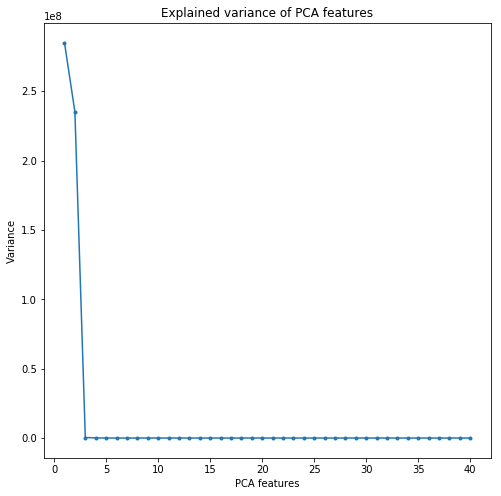

In [20]:
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)
f, axes = plt.subplots(figsize=(8, 8))
axes.plot(range(1, pca.n_components_+1), pca.explained_variance_, marker = '.')
axes.set(xlabel = 'PCA features', ylabel='Variance', title='Explained variance of PCA features')
plt.show()

# Choosing K: The Elbow Sum-of-Squares Method

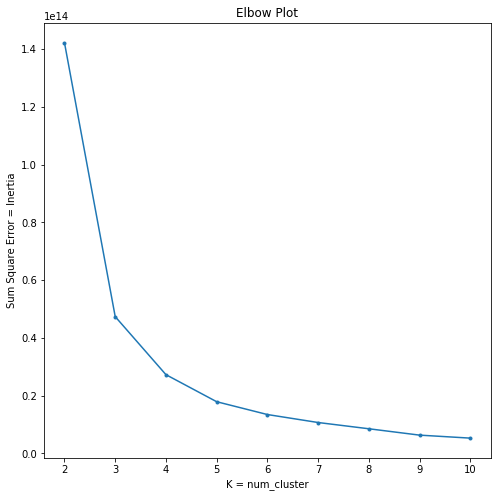

In [21]:
ss = [];
ks = range(2, 11)
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=2)
    labels = kmeans.fit_predict(x_cols)
    ss.append(kmeans.inertia_)
f, axes = plt.subplots(figsize=(8, 8))
axes.plot(ks, ss, marker='.')
axes.set(xlabel='K = num_cluster', ylabel = 'Sum Square Error = Inertia', title = 'Elbow Plot')
plt.show()

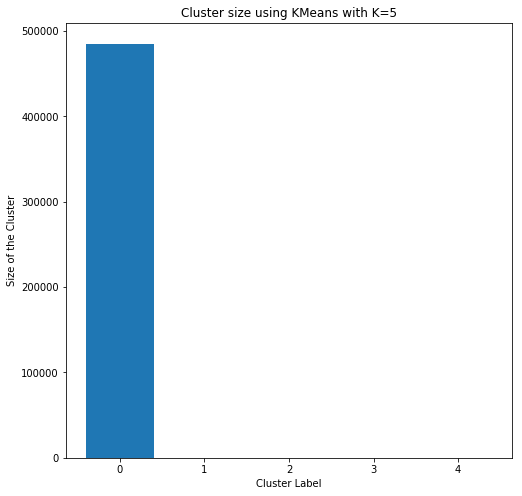

In [29]:
# Pick 9 clusters
kmeans = KMeans(n_clusters=5, random_state=2)
kdd_data_10percent['labels'] = kmeans.fit_predict(x_cols)
cluster_size = kdd_data_10percent.labels.value_counts()
f, axes = plt.subplots(figsize=(8, 8))
axes.bar(cluster_size.index, cluster_size)
axes.set(xlabel='Cluster Label', ylabel='Size of the Cluster', title='Cluster size using KMeans with K=5')
plt.show()
kdd_data_10percent = kdd_data_10percent.drop('labels', axis=1)

# Preprocessing


## Extracting the labels

As depicted previously the testing set has an additional 15 attack types that are not available in training data hence we will need  more general labels to train the model for the classification task.


The 37 attack types available in the dataset can be clustered into four general attack types

- Denial of service attacks
- Remote to Local attacks
- User to Root
- Probe attacks

Our model will perform binary classification of the data to two classes indicating whether the traffic is normal or an Attack, however we will  use the four attack types to analyze the results and calculate performance metrics for each general attack type.

The next section replaces the current outcome field with a Class field that has one of the following values :
- Normal
- Dos
- R2L
- U2R
- Probe